In [1]:
!nvidia-smi

Wed Nov 10 03:58:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip drive/MyDrive/updated_data.zip 

Streaming output truncated to the last 5000 lines.
  inflating: updated_data/without/32_0_1_20170116002309943.jpg.chip.jpg  
  inflating: __MACOSX/updated_data/without/._32_0_1_20170116002309943.jpg.chip.jpg  
  inflating: updated_data/without/29_0_0_20170117180942324.jpg.chip.jpg  
  inflating: __MACOSX/updated_data/without/._29_0_0_20170117180942324.jpg.chip.jpg  
  inflating: updated_data/without/70_1_0_20170117155916072.jpg.chip.jpg  
  inflating: __MACOSX/updated_data/without/._70_1_0_20170117155916072.jpg.chip.jpg  
  inflating: updated_data/without/35_0_0_20170117171451970.jpg.chip.jpg  
  inflating: __MACOSX/updated_data/without/._35_0_0_20170117171451970.jpg.chip.jpg  
  inflating: updated_data/without/8_1_2_20170109203855544.jpg.chip.jpg  
  inflating: __MACOSX/updated_data/without/._8_1_2_20170109203855544.jpg.chip.jpg  
  inflating: updated_data/without/30_0_2_20170116165153226.jpg.chip.jpg  
  inflating: __MACOSX/updated_data/without/._30_0_2_20170116165153226.jpg.chip.jpg

In [3]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [4]:
CFG = {
    'train_BS': 64,
    'valid_BS': 64,
    'lr': 0.01,
    'grad_clip': 0.1,
    'weight_decay': 0.01,
    'epochs': 30,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [5]:
from torchvision.datasets import ImageFolder

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(0.2),
     transforms.Resize((224,224)),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
dataset = ImageFolder('updated_data/', transform=transform) 

# data = pd.read_csv('/content/masked_unmasked/data.csv')
# data = data.drop(data[data['image'] == "masked/.DS_Store"].index)

# train, valid = train_test_split(data, test_size=0.15, random_state=42)

In [6]:
from torch.utils.data import Subset
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    train = Subset(dataset, train_idx)
    valid = Subset(dataset, val_idx)
    return train, valid

train_data, valid_data = train_val_dataset(dataset, 0.2)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG['train_BS'], shuffle=True, pin_memory=False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG['valid_BS'], shuffle=False, pin_memory=False)

In [7]:
import os
import torch
import torch.nn as nn
import numpy as np
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score

class Train:
    def __init__ (self, model, device, optimizer, criterion, scheduler=None):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.model = self.model.to(self.device)
        self.scheduler = scheduler
        # self.x = []

    def train (self, train_loader, epoch, n_examples):
        self.model.train()
        # training_loss = 0
        losses = []
        predicts = []
        correct = []
        description = "\nEPOCH: {} training".format(epoch+1)
        train_bar = tq.tqdm(train_loader, total=len(train_loader), desc=description, position=0, leave=True)
        for images, labels in train_bar:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(images)
            loss = self.criterion(output, labels)

            correct.extend(labels.cpu().numpy())
            predicts.extend(torch.argmax(output, dim=1).cpu().numpy())
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.optimizer.zero_grad()
  
            train_bar.set_postfix(loss=np.mean(losses))
        return np.mean(losses), accuracy_score(predicts, correct)

    def val (self, val_loader, epoch, n_examples):
        self.model.eval()
        losses = []
        predicts = []
        correct = []
        description = "EPOCH: {} validation".format(epoch+1)
        with torch.no_grad():
            valid_bar = tq.tqdm(val_loader, total=len(val_loader), desc=description, position=0, leave=True)
            for images, labels in valid_bar:

                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                loss = self.criterion(output, labels)

                correct.extend(labels.cpu().numpy())
                predicts.extend(torch.argmax(output, dim=1).cpu().numpy())

                losses.append(loss.item())
                valid_bar.set_postfix(loss=np.mean(losses))

        return np.mean(losses), accuracy_score(predicts, correct)


    def learning_rate(self, optimizer):
        for params in optimizer.param_groups:
            return param_group['lr']
    
    def fit(self, ES, model_path, train_loader, val_loader=None, epochs=1, start_epoch=0, fold=0, train_BS=64, valid_BS=64, grad_clip=None):
        
        training_loss_lst = []
        training_acc_lst = []
        val_loss_lst = []
        val_acc_lst = []
        i = 1
        validation = False

        # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        if val_loader is not None:
            validation = True
            # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

        # print("=> Trining Model on: {}\n\n".format(self.device))
        min_loss = np.Inf
        for epoch in range(start_epoch, epochs):
            
            training_loss, training_acc = self.train(train_loader, epoch, len(train_loader)*train_BS)
            training_loss_lst.append(training_loss)
            training_acc_lst.append(training_acc)
            
            if validation:
                val_loss, val_acc = self.val(val_loader, epoch, len(val_loader)*valid_BS)
                val_loss_lst.append(val_loss)
                val_acc_lst.append(val_acc)

                # self.x.append([training_loss, training_acc, val_loss, val_acc])
                print('Train Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(training_loss, training_acc, val_loss, val_acc))
                i += 1
                if i > ES:
                    print('\nEarly Stopping')
                    break
                if val_loss <= min_loss:
                    i = 0
                    if self.scheduler is not None:
                        checkpoint = {
                              'epoch': epoch + 1,
                              'model': self.model.state_dict(),
                              'optimizer': self.optimizer.state_dict(),
                              'scheduler': self.scheduler.state_dict()
                          }
                    else:
                        checkpoint = {
                              'epoch': epoch + 1,
                              'model': self.model.state_dict(),
                              'optimizer': self.optimizer.state_dict()
                          }
                    

                    model_path_1 = os.path.join(model_path, 'model_fold{}.pt'.format(fold))
                    torch.save(checkpoint, model_path_1)
                    print('\nVal loss decreased ({:.4f} -> {:.4f}), Model saved'.format(min_loss, val_loss))
                    min_loss = val_loss
                    
            
            else:
                print('EPOCH: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} '.format(epoch+1, training_loss, training_acc))
                i += 1
                if i >= ES:
                    print('Early Stopping')
                    break
                if training_loss <= min_loss:
                    i = 0
                    print('Loss decreased ({:.4f} -> {:.4f}), model saved at {}'.format(min_loss, training_loss, model_path))
                    min_loss = training_loss

                    if self.scheduler is not None:
                        checkpoint = {
                            'epoch': epoch + 1,
                            'model': self.model.state_dict(),
                            'optimizer': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict()
                        }
                    else:
                        checkpoint = {
                        'epoch': epoch + 1,
                        'model': self.model.state_dict(),
                        'optimizer': self.optimizer.state_dict()
                    }
                    model_path_1 = '{}model_{}.pt'.format(model_path, epoch+1)
                    torch.save(checkpoint, model_path_1)
            
            if self.scheduler is not None:
                self.scheduler.step()

            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            torch.cuda.empty_cache()

        history = {
            'train_loss': training_loss_lst,
            'train_acc': training_acc_lst,
            'val_loss': val_loss_lst,
            'val_acc': val_acc_lst
        }

        return history   

In [8]:
class Model(nn.Module):
    def __init__(self, opt_class):
        super().__init__()
        self.conv11 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv12 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv21 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv22 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv31 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv32 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv41 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv42 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv43 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv51 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv52 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv53 = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, opt_class)
    
    def forward(self, input):
        x = F.relu(self.conv11(input))
        x = F.relu(self.conv12(x))
        x = self.pool(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.pool(x)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = F.relu(self.conv33(x))
        x = self.pool(x)
        x = F.relu(self.conv41(x))
        x = F.relu(self.conv42(x))
        x = F.relu(self.conv43(x))
        x = self.pool(x)
        x = F.relu(self.conv51(x))
        x = F.relu(self.conv52(x))
        x = F.relu(self.conv53(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x =  F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x =  F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [9]:
model = Model(4)
model = model.to(CFG['device'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG['lr'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))

In [10]:
trainer = Train(model=model, device=CFG['device'], optimizer=optimizer, criterion=criterion, scheduler=scheduler)

trainer.fit(ES=3, model_path='../content', train_loader=train_loader, val_loader=valid_loader, epochs=CFG['epochs'], start_epoch=0, fold=0, train_BS=CFG['train_BS'], valid_BS=CFG['train_BS'], grad_clip=CFG['grad_clip'])


EPOCH: 1 training:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 1 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 1.2167 	Train Acc: 0.3853 	Val Loss: 0.8072 	Val Acc: 0.6928

Val loss decreased (inf -> 0.8072), Model saved



EPOCH: 2 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 2 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6375 	Train Acc: 0.7595 	Val Loss: 0.5736 	Val Acc: 0.7737

Val loss decreased (0.8072 -> 0.5736), Model saved



EPOCH: 3 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 3 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4328 	Train Acc: 0.8420 	Val Loss: 0.5419 	Val Acc: 0.8217

Val loss decreased (0.5736 -> 0.5419), Model saved



EPOCH: 4 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 4 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3259 	Train Acc: 0.8802 	Val Loss: 0.3846 	Val Acc: 0.8736

Val loss decreased (0.5419 -> 0.3846), Model saved



EPOCH: 5 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 5 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3306 	Train Acc: 0.8960 	Val Loss: 0.3057 	Val Acc: 0.8976

Val loss decreased (0.3846 -> 0.3057), Model saved



EPOCH: 6 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 6 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2855 	Train Acc: 0.9106 	Val Loss: 0.3128 	Val Acc: 0.8976



EPOCH: 7 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 7 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2560 	Train Acc: 0.9153 	Val Loss: 0.2426 	Val Acc: 0.9064

Val loss decreased (0.3057 -> 0.2426), Model saved



EPOCH: 8 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 8 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4094 	Train Acc: 0.9017 	Val Loss: 0.2194 	Val Acc: 0.9267

Val loss decreased (0.2426 -> 0.2194), Model saved



EPOCH: 9 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 9 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1547 	Train Acc: 0.9469 	Val Loss: 0.1766 	Val Acc: 0.9343

Val loss decreased (0.2194 -> 0.1766), Model saved



EPOCH: 10 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 10 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1590 	Train Acc: 0.9494 	Val Loss: 0.2333 	Val Acc: 0.9128



EPOCH: 11 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 11 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1684 	Train Acc: 0.9488 	Val Loss: 0.1831 	Val Acc: 0.9355



EPOCH: 12 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 12 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1115 	Train Acc: 0.9614 	Val Loss: 0.1534 	Val Acc: 0.9456

Val loss decreased (0.1766 -> 0.1534), Model saved



EPOCH: 13 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 13 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1324 	Train Acc: 0.9611 	Val Loss: 0.4384 	Val Acc: 0.9267



EPOCH: 14 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 14 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1150 	Train Acc: 0.9627 	Val Loss: 0.1355 	Val Acc: 0.9608

Val loss decreased (0.1534 -> 0.1355), Model saved



EPOCH: 15 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 15 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1059 	Train Acc: 0.9693 	Val Loss: 0.2081 	Val Acc: 0.9330



EPOCH: 16 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 16 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.0845 	Train Acc: 0.9703 	Val Loss: 0.1916 	Val Acc: 0.9583



EPOCH: 17 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 17 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.0771 	Train Acc: 0.9798 	Val Loss: 0.1911 	Val Acc: 0.9532



EPOCH: 18 training:   0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 18 validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.0678 	Train Acc: 0.9839 	Val Loss: 0.2999 	Val Acc: 0.9330

Early Stopping


{'train_acc': [0.3852718078381795,
  0.7594816687737042,
  0.8419721871049305,
  0.8802149178255373,
  0.8960176991150443,
  0.9105562579013906,
  0.9152970922882427,
  0.9017067003792667,
  0.9469026548672567,
  0.9494310998735778,
  0.9487989886219975,
  0.961441213653603,
  0.9611251580278128,
  0.9627054361567636,
  0.9693426042983565,
  0.9702907711757269,
  0.9797724399494311,
  0.9838811630847029],
 'train_loss': [1.216686009168625,
  0.6374718505144119,
  0.4327882817387581,
  0.32586557894945145,
  0.3305537088215351,
  0.28545309156179427,
  0.25597527965903283,
  0.4094249194860458,
  0.15467695906758308,
  0.15901044439524412,
  0.16839498028159142,
  0.1115475278440863,
  0.13238528763875365,
  0.11503735864534974,
  0.10589216569438577,
  0.0844767242949456,
  0.07711362130939961,
  0.0678247340884991],
 'val_acc': [0.6927939317319848,
  0.7737041719342604,
  0.8217446270543616,
  0.8735777496839444,
  0.8975979772439949,
  0.8975979772439949,
  0.9064475347661188,
  0.92

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
model = torch.load("model_fold0.pt")['model']
resnet = Model(4)
resnet.load_state_dict(model)
resnet = resnet.to(CFG['device'])

In [12]:
# labels_list = ['masked', 'unmasked']

def find_face(img):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if faces is None:
        return None
    for (x, y, w, h) in faces:
        img = img[y:y+h, x:x+w]
    return img

def pred_label(img, model):
    # img  = find_face(img)
    if img is None:
        return "No face found"
    img = transform(img)
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(CFG['device']))
    print(pred)
    return pred.argmax(1).data[0]

In [13]:
!wget https://static01.nyt.com/images/2020/04/10/video/HowToMakeAMask_Cover_1/HowToMakeAMask_Cover_1-square640.jpg

--2021-11-10 04:39:52--  https://static01.nyt.com/images/2020/04/10/video/HowToMakeAMask_Cover_1/HowToMakeAMask_Cover_1-square640.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66512 (65K) [image/jpeg]
Saving to: ‘HowToMakeAMask_Cover_1-square640.jpg’

HowToMakeAMask_Cove 100%[===================>]  64.95K  --.-KB/s    in 0.01s   

2021-11-10 04:39:52 (5.08 MB/s) - ‘HowToMakeAMask_Cover_1-square640.jpg’ saved [66512/66512]



tensor([[ 5.8345,  5.2218, -7.1903, -9.5240]], device='cuda:0')


tensor(0, device='cuda:0')

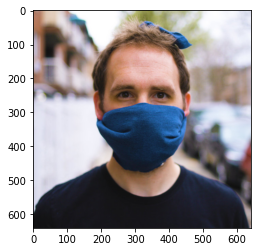

In [14]:
img = cv2.imread('/content/HowToMakeAMask_Cover_1-square640.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

tensor([[ 3.0627, -5.5395,  5.3998, -8.9344]], device='cuda:0')


tensor(2, device='cuda:0')

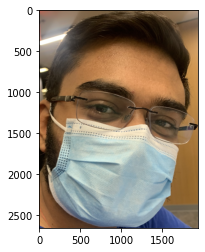

In [15]:
img = cv2.imread('/content/IMG_5457.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

tensor([[ 2.7015, -1.7435,  1.5649, -4.8413]], device='cuda:0')


tensor(0, device='cuda:0')

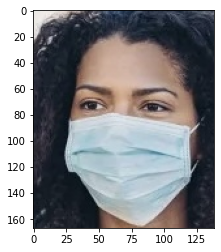

In [26]:
img = cv2.imread('/content/IMG_5456 2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

tensor([[ 1.7221, -0.1023, -1.6413, -1.2620]], device='cuda:0')


tensor(0, device='cuda:0')

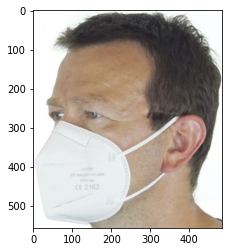

In [16]:
img = cv2.imread('/content/IMG_5458.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

tensor([[ 4.6789,  0.9034, -3.7009, -4.8600]], device='cuda:0')


tensor(0, device='cuda:0')

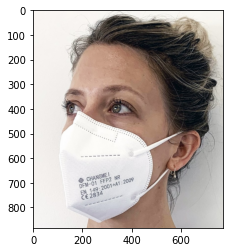

In [19]:
img = cv2.imread('/content/IMG_5382.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

In [17]:
!cp /content/model_fold0.pt /content/drive/MyDrive

tensor([[ 6.1928, -0.1902, -5.2597, -5.0053]], device='cuda:0')


tensor(0, device='cuda:0')

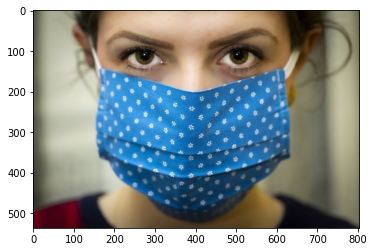

In [25]:
img = cv2.imread('/content/IMG_5459.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

tensor([[-2.4296, -7.5385, 11.6059, -9.5400]], device='cuda:0')


tensor(2, device='cuda:0')

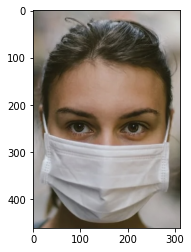

In [24]:
img = cv2.imread('/content/IMG_5374.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)

tensor([[-1.5878, -2.6499,  4.1939, -3.2396]], device='cuda:0')


tensor(2, device='cuda:0')

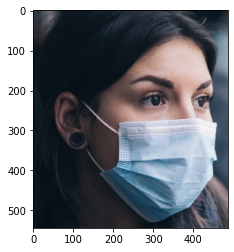

In [21]:
img = cv2.imread('/content/IMG_5375.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, resnet)